## Final Project Submission - Exploratory Data Analysis

Please fill out:
* Student name: Andrew Levinton
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Ahbineet Kulkarni
* Blog post URL:


## Statsmodels debug
- This is because statsmodels was having version issues. this is a workaround
- The code below re-publishes the existing (but private) _centered function as a public attribute to the module already imported in RAM.

In [1]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

## Import necessary libraries

In [2]:

import pandas as pd
import numpy as np
import datetime as dt

# data visualiztion
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# regression modeling
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# # model validation
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split 
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")


# gain access to apis
import json as js


plt.style.use('classic')

## Define Functions

In [3]:
# # Grabbing and categorizing vifs

# def get_VIFs(vif_data, df):
    
#     vif_data = pd.DataFrame()
#     vif_data["feature"] = df_numerical.columns
  
#     # calculating VIF for each feature
#     vif_data["VIF"] = [variance_inflation_factor(df_numerical.values, i)
#                               for i in range(len(df_numerical.columns))]


#     vif_data['VIF_values'] = vif_data["feature"].astype(str) + ': ' + vif_data["VIF"].round(2).astype(str)
#     vif_data['VIF'] = vif_data['VIF'].astype(float)

#     vif_data['sliced_vifs'] = vif_data['VIF'].apply(lambda x: 'good_VIF' if float(x) <=5\
#                                              else 'questionable_VIF' if float(x) <=10\
#                                              else 'bad_VIF' if float(x) > 10\
#                                              else x)
    
#     return vif_data.sort_values('sliced_vifs')


def get_vifs(data):
    # Get a list of the column names
    cols = data.columns

    # Create an empty DataFrame to hold the VIF results
    vif_data = pd.DataFrame()

    # Loop through each column and calculate the VIF
    for i in range(len(cols)):
        vif = variance_inflation_factor(data[cols].values, i)
        vif_data = vif_data.append({'Variable': cols[i], 'VIF': vif}, ignore_index=True)

    # Print the VIF results
    return print(vif_data)

# get ols model and plot residual distribution
def get_OLS_model(name, X, y):
    model = sm.OLS(y, sm.add_constant(X))
    results = model.fit()
    model_residual = results.resid
    
    return print(results.summary()), plt.suptitle(f'Residual distribution for {name} model'), sns.distplot(model_residual), plt.show()

#get qq and histogram plots 
def plot_hist_qq(df, target_col):
    """
    Creates a histogram and QQ-plot for a given dataframe and target column.

    Args:
        df (pandas.DataFrame): The dataframe to plot.
        target_col (str): The name of the target column.

    Returns:
        None
    """
    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot histogram on the first subplot
    axs[0].hist(df[target_col], bins=30)
    axs[0].set_xlabel(target_col)
    axs[0].set_ylabel('Frequency')

    # Plot QQ-plot on the second subplot
    stats.probplot(df[target_col], plot=axs[1])
    axs[1].set_xlabel('Theoretical quantiles')
    axs[1].set_ylabel('Sample quantiles')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

## Read in dataset, check length

In [11]:
cd ..

C:\Users\alevi\Documents\Flatiron\dsc-data-science-env-config\Course_Folder\Phase_2\Housing_Linear_Model_Project


In [12]:
path = './data/kc_house_data.csv'

In [13]:
df = pd.read_csv(path)
len(df)

30155

### Checking dtypes

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

## Linear Model must meet the following assumptions:

### Simple Linear Regression on select features
Assumption check:
- Is it linear?
- Is it normal?
    - histogram
    - QQ-plot
- Is it homoscedastic?

## The process for building this linear model:
- Prep data for linear model regression: This involves dropping null values, dropping "bad data", as well as engineering features to assist in assuming linearization
- Key scores to look at:
- `R-Squared ( or the coefficient of determination)` - a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable. In other words, r-squared shows how well the data fit the regression model (the goodness of fit).
- `Correlation coefficients` - check to see what variables seem relatable to the target variable (price)
- `residual plots` - check how far data compares to the mean. Data should be normally distributed to avoid skewness of the mean
- `variance inflation factor` - level of statistical skew
- `Root mean squared erro`r - how far predictions fall from measured true values using Euclidean distance.
- `pvalues of independent variables` - measures how statistically significant the independent variables are

## Data Preparation

## Dropping nullls

In [15]:
df.dropna(inplace=True)

### Recheck length

In [16]:
len(df)

30111

### Looking at Washington state

In [17]:
df['address'] = df['address'].str.lower()

In [18]:
df = df[df['address'].str.contains('washington')]

In [19]:
len(df)

29208

## Grabbing Zipcodes

In [20]:
df['zipcode'] = df['address'].apply(lambda x: x.split(',')[2].split(' ')[-1])

In [21]:
df['zipcode'] = df['zipcode'].astype(str)

In [22]:
df['zipcode'].unique()

array(['98055', '98133', '98178', '98118', '98027', '98166', '98030',
       '98023', '98019', '98144', '98031', '98092', '98103', '98006',
       '98136', '98007', '98038', '98057', '98077', '98126', '98053',
       '98039', '98107', '98008', '98155', '98168', '98199', '98004',
       '98045', '98052', '98011', '98002', '98033', '98116', '98198',
       '98125', '98001', '98112', '98034', '98056', '98059', '98005',
       '98040', '98014', '98106', '98029', '98122', '98003', '98117',
       '98042', '98119', '98065', '98022', '98072', '98058', '98108',
       '98115', '98074', '98105', '98024', '98146', '98109', '98102',
       '98028', '98188', '98177', '98075', '98010', '98148', '98047',
       '98032', '98070', '98051', '98288', '98354', '98272', '98296',
       '98271', '98050', '63090', 'seattle', '98387', '15301', '98251',
       '98223', '98338', '98224', '98372', '98663', '99202', '99403',
       '98422', '99203', '99223', '98270'], dtype=object)

## Categorizing waterfronts

In [23]:
duwamish = ['98168']
elliot_bay_zips= ['98119','98104','98129','98132','98127','98125','98195','98101','98134','98170','98139','98131','98181'] 
puget_sound = ['98071','98083','98013','98070','98031','98131','98063','98195','98207','98190'] 
lake_union = ['98109']
lake_washington = ['98072','98077'] 
lake_sammamish = ['98074','98075','98029'] 
other = ['00000']


df['waterfront_loc'] = df['zipcode'].apply(lambda x: 'Duwamish' if x=='98168'\
                                          else 'Elliot Bay' if x in elliot_bay_zips\
                                          else 'Puget Sound' if x in puget_sound\
                                          else 'Lake Union' if x in lake_union\
                                          else 'Lake Washington' if x in lake_washington\
                                          else 'Lake Sammamish' if x in lake_sammamish\
                                          else 'other')

In [24]:
df['waterfront_loc'].value_counts()

other              25497
Lake Sammamish      1159
Elliot Bay           730
Puget Sound          721
Lake Washington      589
Duwamish             383
Lake Union           129
Name: waterfront_loc, dtype: int64

## Filter by state of Washington Zipcodes

In [25]:
df = df[df['zipcode'].str.startswith('98') | df['zipcode'].str.contains('seattle')]

## One Hot Encoding Waterfronts

In [26]:
waterfront_dummies = pd.get_dummies(df['waterfront_loc'], prefix='water', drop_first=True)

In [27]:
waterfront_dummies

,water_Elliot Bay,water_Lake Sammamish,water_Lake Union,water_Lake Washington,water_Puget Sound,water_other
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1
...,...,...,...,...,...,...
30150,0,0,0,0,0,1
30151,0,0,0,0,0,1
30152,0,0,0,0,0,1
30153,0,0,0,0,0,1


In [28]:
len(df) 

29200

In [29]:
len(df) == len(waterfront_dummies)

True

In [30]:
df = pd.concat([df,waterfront_dummies], axis=1)

## replacing seattle with seattle zipcode

In [31]:
df['zipcode'] = df['zipcode'].apply(lambda x: '98101' if x=='seattle' else x)

## recheck zipcodes

In [32]:
df['zipcode'].unique()

array(['98055', '98133', '98178', '98118', '98027', '98166', '98030',
       '98023', '98019', '98144', '98031', '98092', '98103', '98006',
       '98136', '98007', '98038', '98057', '98077', '98126', '98053',
       '98039', '98107', '98008', '98155', '98168', '98199', '98004',
       '98045', '98052', '98011', '98002', '98033', '98116', '98198',
       '98125', '98001', '98112', '98034', '98056', '98059', '98005',
       '98040', '98014', '98106', '98029', '98122', '98003', '98117',
       '98042', '98119', '98065', '98022', '98072', '98058', '98108',
       '98115', '98074', '98105', '98024', '98146', '98109', '98102',
       '98028', '98188', '98177', '98075', '98010', '98148', '98047',
       '98032', '98070', '98051', '98288', '98354', '98272', '98296',
       '98271', '98050', '98101', '98387', '98251', '98223', '98338',
       '98224', '98372', '98663', '98422', '98270'], dtype=object)

In [33]:
len(df['zipcode'].unique())

89

In [34]:
df['city'] = df['address'].apply(lambda x: x.split(',')[1].strip())

In [35]:
data = df

data['count'] = 1

data = data.groupby('city')['count'].sum().reset_index().sort_values('count', ascending=False)
data.head(15)

,city,count
50,seattle,9363
47,renton,1943
29,kent,1583
5,auburn,1508
8,bellevue,1482
30,kirkland,1270
24,federal way,1167
46,redmond,985
48,sammamish,976
33,maple valley,887


## A look at school ratings

As an educator, I thought it may be interesting to look at the GreatSchools API to see if the housing prices are correlated at all with school district ratings. A request was permitted by the GreatSchools company and all data will come from this API on school ratings. 

In [36]:
def get_zips_and_ratings(schools):
    school_zipcodes = []
    for i, school in enumerate(schools):
    
        school_zipcodes.append(schools[i]['zip'])
     
    school_ratings = []
    for i, school in enumerate(schools):

        school_ratings.append(schools[i]['rating'])
    zips_and_ratings = pd.concat([pd.DataFrame(school_ratings),pd.DataFrame(school_zipcodes)],axis=1)
    zips_and_ratings.columns = ['rating','zipcode']
    return zips_and_ratings



## Seattle

In [37]:
try:
    from urllib.request import Request, urlopen  # Python 3
except ImportError:
    from urllib2 import Request, urlopen  # Python 2

req = Request('https://gs-api.greatschools.org/schools?city=seattle&state=wa&limit=100&county=king_county')
req.add_header('X-API-Key', 'Zu2Iw9Fnpt694hy7mqPkG72Vr7ZsOEKW5KZFg0uq')   # replace ‘myapikey’ with your api key
content = urlopen(req).read()


In [38]:
data = js.loads(content)

schools = data['schools']

seattle_zipsandratings = get_zips_and_ratings(schools)

seattle_zipsandratings['rating'] =seattle_zipsandratings['rating'].astype(int)
seattle_zipsandratings = seattle_zipsandratings.groupby('zipcode')['rating'].mean().reset_index()

seattle_zipsandratings.columns = ['zipcode','avg_rating']
seattle_zipsandratings

,zipcode,avg_rating
0,98102,8.000000
1,98103,6.500000
2,98105,7.500000
3,98106,3.000000
4,98107,6.000000
5,98108,5.200000
6,98109,7.000000
7,98112,5.000000
8,98115,7.666667
9,98116,7.666667


## Renton

In [39]:
try:
    from urllib.request import Request, urlopen  # Python 3
except ImportError:
    from urllib2 import Request, urlopen  # Python 2

req = Request('https://gs-api.greatschools.org/schools?city=kent&state=wa&limit=100&county=king_county')
req.add_header('X-API-Key', 'Zu2Iw9Fnpt694hy7mqPkG72Vr7ZsOEKW5KZFg0uq')   # replace ‘myapikey’ with your api key
content = urlopen(req).read()

In [40]:
data = js.loads(content)

schools = data['schools']

kent_zipsandratings = get_zips_and_ratings(schools)

kent_zipsandratings = kent_zipsandratings.dropna()

kent_zipsandratings['rating'] = kent_zipsandratings['rating'].astype(int)
kent_zipsandratings = kent_zipsandratings.groupby('zipcode')['rating'].mean().reset_index()
kent_zipsandratings.columns = ['zipcode','avg_rating']
kent_zipsandratings

,zipcode,avg_rating
0,98030,4.500000
1,98031,4.111111
2,98032,3.166667
3,98042,5.166667


## Auburn

In [41]:
try:
    from urllib.request import Request, urlopen  # Python 3
except ImportError:
    from urllib2 import Request, urlopen  # Python 2

req = Request('https://gs-api.greatschools.org/schools?city=auburn&state=wa&limit=100&county=king_county')
req.add_header('X-API-Key', 'Zu2Iw9Fnpt694hy7mqPkG72Vr7ZsOEKW5KZFg0uq')   # replace ‘myapikey’ with your api key
content = urlopen(req).read()

In [42]:
data = js.loads(content)

schools = data['schools']

auburn_zipsandratings = get_zips_and_ratings(schools)
auburn_zipsandratings = auburn_zipsandratings.dropna()
auburn_zipsandratings['rating'] = auburn_zipsandratings['rating'].astype(int)

auburn_zipsandratings = auburn_zipsandratings.groupby('zipcode')['rating'].mean().reset_index()
auburn_zipsandratings.columns = ['zipcode','avg_rating']

auburn_zipsandratings

,zipcode,avg_rating
0,98001,4.000000
1,98002,3.888889
2,98092,4.636364


## Bellevue

In [43]:
try:
    from urllib.request import Request, urlopen  # Python 3
except ImportError:
    from urllib2 import Request, urlopen  # Python 2

req = Request('https://gs-api.greatschools.org/schools?city=kirkland&state=wa&limit=100&county=king_county')
req.add_header('X-API-Key', 'Zu2Iw9Fnpt694hy7mqPkG72Vr7ZsOEKW5KZFg0uq')   # replace ‘myapikey’ with your api key
content = urlopen(req).read()

In [44]:
data = js.loads(content)

schools = data['schools']
schools
belleview_zipsandratings = get_zips_and_ratings(schools)

belleview_zipsandratings = belleview_zipsandratings.dropna()

belleview_zipsandratings['rating'] = belleview_zipsandratings['rating'].astype(int)
belleview_zipsandratings = belleview_zipsandratings.groupby('zipcode')['rating'].mean().reset_index()
belleview_zipsandratings.columns = ['zipcode','avg_rating']
belleview_zipsandratings

,zipcode,avg_rating
0,98033,7.444444
1,98034,6.090909


## Kirkland

In [45]:
try:
    from urllib.request import Request, urlopen  # Python 3
except ImportError:
    from urllib2 import Request, urlopen  # Python 2

req = Request('https://gs-api.greatschools.org/schools?city=kirkland&state=wa&limit=100&county=king_county')
req.add_header('X-API-Key', 'Zu2Iw9Fnpt694hy7mqPkG72Vr7ZsOEKW5KZFg0uq')   # replace ‘myapikey’ with your api key
content = urlopen(req).read()

In [46]:
data = js.loads(content)

schools = data['schools']

kirkland_zipsandratings = get_zips_and_ratings(schools)
kirkland_zipsandratings = kirkland_zipsandratings.dropna()
kirkland_zipsandratings['rating'] = kirkland_zipsandratings['rating'].astype(int)

kirkland_zipsandratings = kirkland_zipsandratings.groupby('zipcode')['rating'].mean().reset_index()
kirkland_zipsandratings.columns = ['zipcode','avg_rating']

kirkland_zipsandratings

,zipcode,avg_rating
0,98033,7.444444
1,98034,6.090909


## sammamish

In [47]:
try:
    from urllib.request import Request, urlopen  # Python 3
except ImportError:
    from urllib2 import Request, urlopen  # Python 2

req = Request('https://gs-api.greatschools.org/schools?city=sammamish&state=wa&limit=100&county=king_county')
req.add_header('X-API-Key', 'Zu2Iw9Fnpt694hy7mqPkG72Vr7ZsOEKW5KZFg0uq')   # replace ‘myapikey’ with your api key
content = urlopen(req).read()

In [48]:
data = js.loads(content)

schools = data['schools']
schools
sammamish_zipsandratings = get_zips_and_ratings(schools)
sammamish_zipsandratings
sammamish_zipsandratings = sammamish_zipsandratings.dropna()
sammamish_zipsandratings['rating'] = sammamish_zipsandratings['rating'].astype(int)

sammamish_zipsandratings = sammamish_zipsandratings.groupby('zipcode')['rating'].mean().reset_index()
sammamish_zipsandratings.columns = ['zipcode','avg_rating']

sammamish_zipsandratings

,zipcode,avg_rating
0,98074,8.5
1,98075,8.6


In [49]:
try:
    from urllib.request import Request, urlopen  # Python 3
except ImportError:
    from urllib2 import Request, urlopen  # Python 2

req = Request('https://gs-api.greatschools.org/schools?city=redmond&state=wa&limit=100&county=king_county')
req.add_header('X-API-Key', 'Zu2Iw9Fnpt694hy7mqPkG72Vr7ZsOEKW5KZFg0uq')   # replace ‘myapikey’ with your api key
content = urlopen(req).read()

In [50]:
data = js.loads(content)

schools = data['schools']
schools
redmond_zipsandratings = get_zips_and_ratings(schools)
redmond_zipsandratings
redmond_zipsandratings = redmond_zipsandratings.dropna()
redmond_zipsandratings['rating'] = redmond_zipsandratings['rating'].astype(int)

redmond_zipsandratings = redmond_zipsandratings.groupby('zipcode')['rating'].mean().reset_index()
redmond_zipsandratings.columns = ['zipcode','avg_rating']

redmond_zipsandratings

,zipcode,avg_rating
0,98052,7.545455
1,98053,8.400000


## Burien

In [51]:
try:
    from urllib.request import Request, urlopen  # Python 3
except ImportError:
    from urllib2 import Request, urlopen  # Python 2

req = Request('https://gs-api.greatschools.org/schools?city=burien&state=wa&limit=100&county=king_county')
req.add_header('X-API-Key', 'Zu2Iw9Fnpt694hy7mqPkG72Vr7ZsOEKW5KZFg0uq')   # replace ‘myapikey’ with your api key
content = urlopen(req).read()

In [52]:
data = js.loads(content)

schools = data['schools']
schools
burien_zipsandratings = get_zips_and_ratings(schools)
burien_zipsandratings
burien_zipsandratings = burien_zipsandratings.dropna()
burien_zipsandratings['rating'] = burien_zipsandratings['rating'].astype(int)

burien_zipsandratings = burien_zipsandratings.groupby('zipcode')['rating'].mean().reset_index()
burien_zipsandratings.columns = ['zipcode','avg_rating']

burien_zipsandratings

,zipcode,avg_rating
0,98146,4.500000
1,98148,3.500000
2,98166,3.666667
3,98168,2.000000


## woodinville

In [53]:
try:
    from urllib.request import Request, urlopen  # Python 3
except ImportError:
    from urllib2 import Request, urlopen  # Python 2

req = Request('https://gs-api.greatschools.org/schools?city=woodinville&state=wa&limit=100&county=king_county')
req.add_header('X-API-Key', 'Zu2Iw9Fnpt694hy7mqPkG72Vr7ZsOEKW5KZFg0uq')   # replace ‘myapikey’ with your api key
content = urlopen(req).read()

In [54]:
data = js.loads(content)

schools = data['schools']
schools
woodinville_zipsandratings = get_zips_and_ratings(schools)
woodinville_zipsandratings
woodinville_zipsandratings = woodinville_zipsandratings.dropna()
woodinville_zipsandratings['rating'] = woodinville_zipsandratings['rating'].astype(int)
woodinville_zipsandratings = woodinville_zipsandratings.groupby('zipcode')['rating'].mean().reset_index()
woodinville_zipsandratings.columns = ['zipcode','avg_rating']

woodinville_zipsandratings

,zipcode,avg_rating
0,98072,7.4
1,98077,7.5


## Combining them all

In [55]:
all_zips = pd.concat([belleview_zipsandratings,auburn_zipsandratings,kent_zipsandratings,seattle_zipsandratings,kirkland_zipsandratings,sammamish_zipsandratings, redmond_zipsandratings, burien_zipsandratings, woodinville_zipsandratings])

In [56]:
pwd

'C:\\Users\\alevi\\Documents\\Flatiron\\dsc-data-science-env-config\\Course_Folder\\Phase_2\\Housing_Linear_Model_Project'

In [57]:
 all_zips.to_csv('school_ratings_by_zipcode.csv', index=False)

In [58]:
import pandas as pd

# Create a dictionary from the zipcode dataframe
zip_dict = all_zips.set_index('zipcode')['avg_rating'].to_dict()

# Load your larger dataframe


# Assign the ratings from the zipcode dictionary to the large dataframe
df['school_rating'] = df['zipcode'].apply(lambda x: zip_dict.get(x, None))

# The above line applies the lambda function to each element of the 'zipcode' column of the large dataframe. 
# If the zipcode is present in the zip_dict, its corresponding rating is assigned to the 'rating' column. 
# If not, None is assigned.

# You can then save the updated large dataframe to a new csv file
df['school_rating'].isnull().sum()

11315

In [59]:
mean_val = df['school_rating'].mean()

In [60]:
df['school_rating'] = df['school_rating'].fillna(mean_val)

In [61]:
df['school_rating'] 

0        5.937719
1        6.500000
2        4.500000
3        4.000000
4        5.937719
           ...   
30150    6.500000
30151    7.666667
30152    3.500000
30153    5.937719
30154    3.500000
Name: school_rating, Length: 29200, dtype: float64

In [62]:
df = df.drop('count', axis =1)

## Observing correlation matrix for possible features that can be used with the price

In [63]:
df.corr()['price'].abs().sort_values(ascending=False)

price                    1.000000
sqft_living              0.616741
sqft_above               0.546108
bathrooms                0.488039
sqft_patio               0.317623
lat                      0.296212
bedrooms                 0.290994
sqft_garage              0.267477
school_rating            0.251165
sqft_basement            0.246548
floors                   0.199285
water_Lake Sammamish     0.141426
yr_built                 0.105877
sqft_lot                 0.086790
yr_renovated             0.085506
long                     0.081940
water_Lake Washington    0.070383
water_Puget Sound        0.068457
water_other              0.064781
water_Lake Union         0.035352
id                       0.030237
water_Elliot Bay         0.004859
Name: price, dtype: float64

### Observations
- At first glance, it appears that sqft_living, sqft_above and bathrooms are the strongest correlated features to the price. 
- Further investigation is needed to measure the validity of the variables. They may be correlated with the price due to skewness or other factors that can make the correlation a deceptively "good" feature.

## Changing categorical variables to numerical columns - this needs to be done if we want to use them in a linear model

In [64]:
#extracting grade as an integer
df['grade'] = df['grade'].apply(lambda x: int(str(x.split(' ')[0])))

# replacing conditions with values
cond_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
df.condition.replace(to_replace=cond_dict,inplace=True)

#changing date to datetime object, get day and month
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear

## Recheck dtypes

In [65]:
df.dtypes

id                                int64
date                     datetime64[ns]
price                           float64
bedrooms                          int64
bathrooms                       float64
sqft_living                       int64
sqft_lot                          int64
floors                          float64
waterfront                       object
greenbelt                        object
nuisance                         object
view                             object
condition                         int64
grade                             int64
heat_source                      object
sewer_system                     object
sqft_above                        int64
sqft_basement                     int64
sqft_garage                       int64
sqft_patio                        int64
yr_built                          int64
yr_renovated                      int64
address                          object
lat                             float64
long                            float64


In [66]:
df['grade'].value_counts()

7     11553
8      8863
9      3597
6      2848
10     1350
11      402
5       385
12      122
4        46
13       24
3         9
2         1
Name: grade, dtype: int64

In [67]:
df.yr_renovated.value_counts()

0       27832
2021       69
2006       49
2018       44
1990       42
        ...  
1942        1
1951        1
1948        1
1972        1
1924        1
Name: yr_renovated, Length: 82, dtype: int64

In [68]:
df.yr_built.value_counts()

2021    1358
1968     514
1978     493
1977     484
1967     474
        ... 
1901      39
1934      38
1935      38
1902      36
1933      30
Name: yr_built, Length: 123, dtype: int64

### The yr_renovated is "zero inflated" - 0 meaning there have been no renovations

In [69]:
df.dtypes

id                                int64
date                     datetime64[ns]
price                           float64
bedrooms                          int64
bathrooms                       float64
sqft_living                       int64
sqft_lot                          int64
floors                          float64
waterfront                       object
greenbelt                        object
nuisance                         object
view                             object
condition                         int64
grade                             int64
heat_source                      object
sewer_system                     object
sqft_above                        int64
sqft_basement                     int64
sqft_garage                       int64
sqft_patio                        int64
yr_built                          int64
yr_renovated                      int64
address                          object
lat                             float64
long                            float64


### Extracting Numerical Predictors by filtering dtypes

In [70]:
df.dtypes.unique()

array([dtype('int64'), dtype('<M8[ns]'), dtype('float64'), dtype('O'),
       dtype('uint8')], dtype=object)

In [71]:
# categorizing dtypes
numerical_types = ['int64','float64']
numerical_predictors = list(df.select_dtypes(include=numerical_types))
numerical_predictors

['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'school_rating',
 'month',
 'day_of_year']

### Create dataframe of numerical values

In [72]:
# df[numerical_predictors] selects only numerical columns
df_numerical = df[numerical_predictors]

In [73]:
df_numerical.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'sqft_garage', 'sqft_patio', 'yr_built', 'yr_renovated', 'lat', 'long',
       'school_rating', 'month', 'day_of_year'],
      dtype='object')

In [74]:
len(df_numerical)

29200

In [75]:
len(waterfront_dummies)

29200

## Dropping price to isolate predictors

In [76]:
df_numerical = df_numerical.drop(['id','price'],axis=1)


In [77]:
df_numerical['floors'] = df['floors'].astype(float)

### Calculating variance inflation factor [VIF]

#### VIF levels:

- Good: VIF <= 5

- Moderate/Questionable: VIF >=5 and VIF <= 10

- Throw out: VIF >= 10


In [78]:
df_numerical.isnull().sum()

bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
condition        0
grade            0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
lat              0
long             0
school_rating    0
month            0
day_of_year      0
dtype: int64

In [79]:
get_vifs(df_numerical)

         Variable            VIF
0        bedrooms      24.768622
1       bathrooms      26.263735
2     sqft_living     119.808110
3        sqft_lot       1.140594
4          floors      17.177547
5       condition      31.150197
6           grade     133.035571
7      sqft_above      92.874304
8   sqft_basement       7.075288
9     sqft_garage       4.675596
10     sqft_patio       2.240790
11       yr_built    9263.218882
12   yr_renovated       1.211647
13            lat  136585.268881
14           long  146658.438892
15  school_rating      22.635104
16          month     697.233857
17    day_of_year     612.219197


### It appears at first glance that the data only yields a small set of independent variables that are not highly collinear with eachother. This will be looked at again after the removal of outliers, and the transformation of data. 

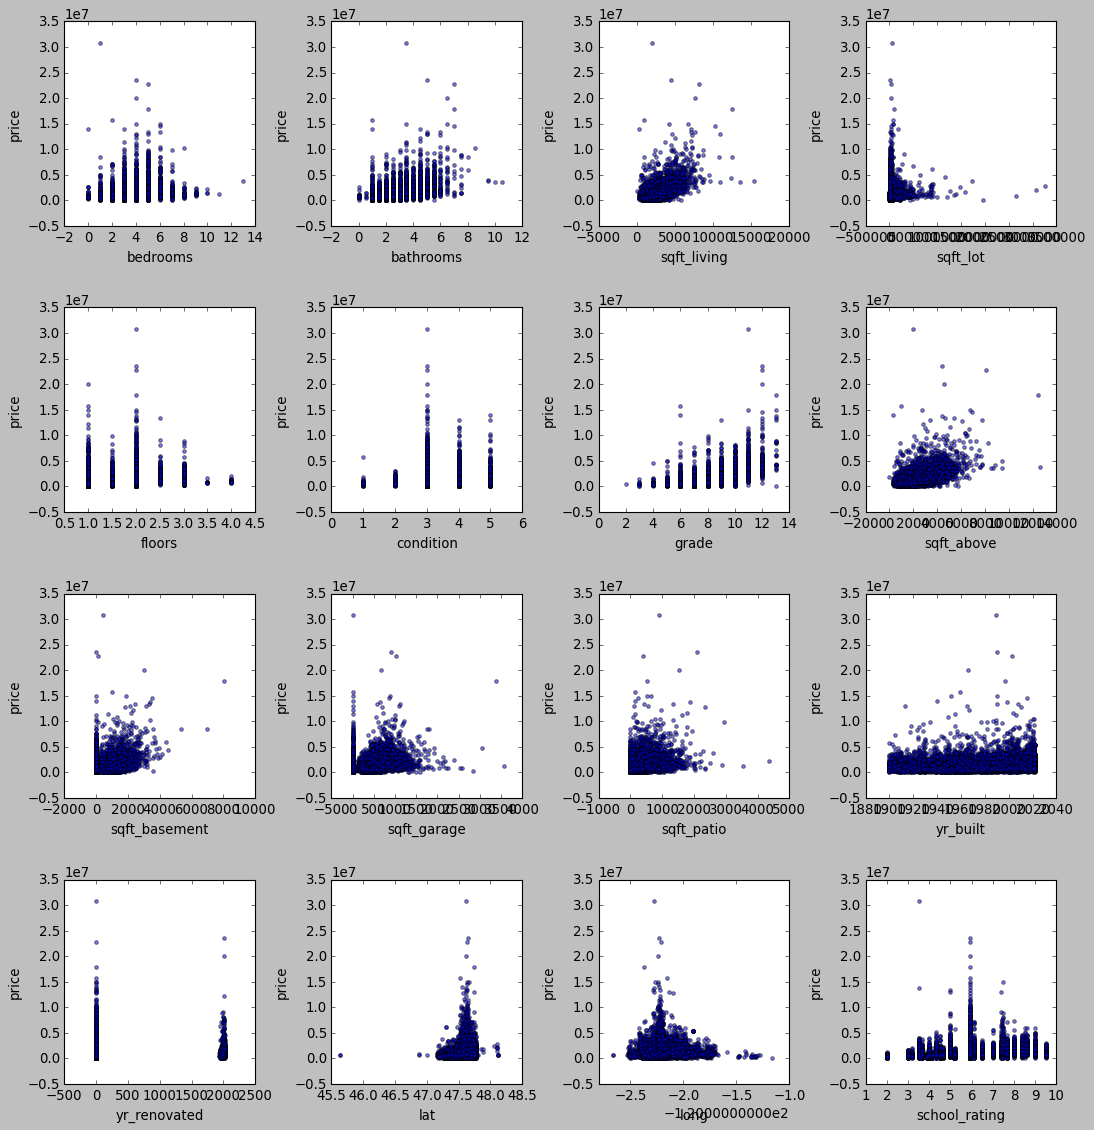

In [80]:
# Specify the dependent variable and independent variables
y_col = 'price'
x_cols = [col for col in df_numerical.columns if col != y_col][:16]  # Use the first 15 independent variables

# Create scatter plot matrix
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, x_var in enumerate(x_cols):
    row, col = divmod(i, 4)
    axs[row, col].scatter(df_numerical[x_var], df[y_col], alpha=0.5, s=10)
    axs[row, col].set_xlabel(x_var)
    axs[row, col].set_ylabel(y_col)

# Adjust plot layout
fig.subplots_adjust(top=0.93, hspace=0.4, wspace=0.4)

# Show the plot
plt.show()

### Extracting Categorical String Predictors

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29200 entries, 0 to 30154
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     29200 non-null  int64         
 1   date                   29200 non-null  datetime64[ns]
 2   price                  29200 non-null  float64       
 3   bedrooms               29200 non-null  int64         
 4   bathrooms              29200 non-null  float64       
 5   sqft_living            29200 non-null  int64         
 6   sqft_lot               29200 non-null  int64         
 7   floors                 29200 non-null  float64       
 8   waterfront             29200 non-null  object        
 9   greenbelt              29200 non-null  object        
 10  nuisance               29200 non-null  object        
 11  view                   29200 non-null  object        
 12  condition              29200 non-null  int64         
 13  g

In [82]:
categorical_types = ['O']
categorical_predictors = list(df.select_dtypes(include=categorical_types))
categorical_predictors

['waterfront',
 'greenbelt',
 'nuisance',
 'view',
 'heat_source',
 'sewer_system',
 'address',
 'zipcode',
 'waterfront_loc',
 'city']

In [83]:
df_categorical = df[categorical_predictors]

In [84]:
df_categorical

,waterfront,greenbelt,nuisance,view,heat_source,sewer_system,address,zipcode,waterfront_loc,city
0,NO,NO,NO,NONE,Gas,PUBLIC,"2102 southeast 21st court, renton, washington ...",98055,other,renton
1,NO,NO,YES,AVERAGE,Oil,PUBLIC,"11231 greenwood avenue north, seattle, washing...",98133,other,seattle
2,NO,NO,NO,AVERAGE,Gas,PUBLIC,"8504 south 113th street, seattle, washington 9...",98178,other,seattle
3,NO,NO,NO,AVERAGE,Gas,PUBLIC,"4079 letitia avenue south, seattle, washington...",98118,other,seattle
4,NO,NO,YES,NONE,Electricity,PUBLIC,"2193 northwest talus drive, issaquah, washingt...",98027,other,issaquah
...,...,...,...,...,...,...,...,...,...,...
30150,NO,NO,NO,NONE,Oil,PUBLIC,"4673 eastern avenue north, seattle, washington...",98103,other,seattle
30151,NO,NO,NO,FAIR,Gas,PUBLIC,"4131 44th avenue southwest, seattle, washingto...",98116,other,seattle
30152,NO,NO,YES,NONE,Gas,PUBLIC,"910 martin luther king jr way, seattle, washin...",98122,other,seattle
30153,NO,NO,NO,NONE,Gas,PUBLIC,"17127 114th avenue southeast, renton, washingt...",98055,other,renton


# Model #1

In [85]:
model_data = df_numerical

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     1720.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:30:36   Log-Likelihood:            -4.3106e+05
No. Observations:               29200   AIC:                         8.622e+05
Df Residuals:                   29181   BIC:                         8.623e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -6.06e+07      4e+06    -15.154

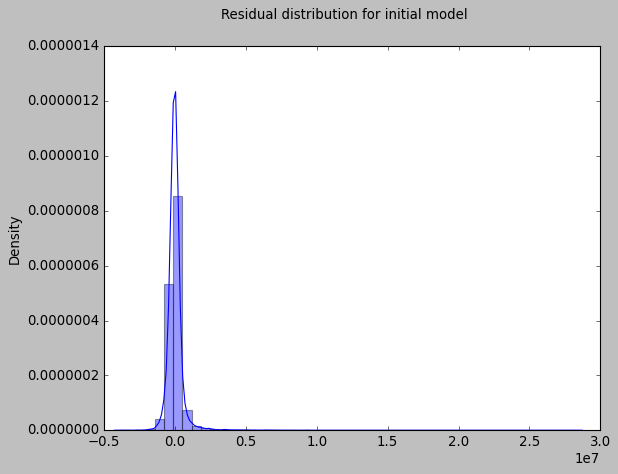

(None,
 Text(0.5, 0.98, 'Residual distribution for initial model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [86]:
get_OLS_model('initial',X = model_data, y = df['price'])

# Observations

p_value > 0.05

- `longitude`**
- `month`

 - month was not anticipated as an effective predictor because it is not typical for the season to affect the sale price of a house
 
 Additional Observations:
 - The adjusted r-squared value is .514, indicating that his model can explain approximately 51.4% of the data.
 -  Skew: A kurtosis value between -2 and +2 is good to prove normalcy. The skew score is 10.065, indicating that this model is heavily skewed. This will be addressed through transformations to normalize the data. 

## Possible Improvements to be made to model:
    - dropping of variables that are not statistically significant (Pval > 0.05)
    - addition of categorial variables(one hot encoded)
    - location would possibly be the most interesting variable, mapped against the waterfront or view variable
    - transformation of data to satisfy normality assumption -ex: log transformation or square root transformation
    - removal of outliers: Outliers in this case will be considered to be any data falling greater than 
      3 standard deviations outside the mean
### Goals
    - improve skewness - removal of outliers
    - reduce homoscedacity - reduce value of VIFs
    - increase rsquared to promote higher level explanation of data from model

# Categorical data Exploratory Analysis and Engineering

The goal of this section will be to add in meaningful categorical data to the model, to be OneHotEncoded once prepped. For this, we first look at the categorical data. 

In [87]:
df_categorical.columns

Index(['waterfront', 'greenbelt', 'nuisance', 'view', 'heat_source',
       'sewer_system', 'address', 'zipcode', 'waterfront_loc', 'city'],
      dtype='object')

## Possible categorical variables of interest: 

* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `address` - The street address

The grade and condition are already onehotencoded in the model and could be changed to a numerical variable, so this part of the analysis will focus on the string categorical variables. 

The address appears to be the most interesting variable in the batch because it can be mapped against the waterfronts or the quality of view from the houses. For this, we will extrapolate features of the address to reduce and categorize the location. 

In [88]:
df['waterfront'].unique()

array(['NO', 'YES'], dtype=object)

In [89]:
# convert waterfront into numeric boolean
waterfront_bool_dict = {'YES':1,'NO':0,np.nan:0}
df_categorical.waterfront.replace(to_replace=waterfront_bool_dict,inplace=True)

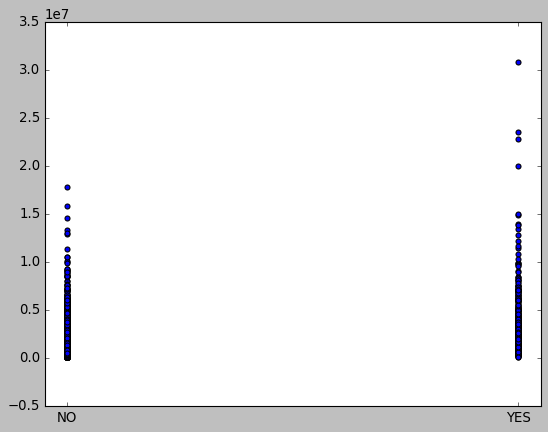

In [90]:
plt.scatter(x=df['waterfront'], y=df['price'])

In [91]:
df['nuisance'].unique()

array(['NO', 'YES'], dtype=object)

In [92]:
# convert nuisance into numeric boolean
nuisance_bool_dict = {'YES':1,'NO':0,np.nan:0}
df_categorical.nuisance.replace(to_replace=nuisance_bool_dict,inplace=True)

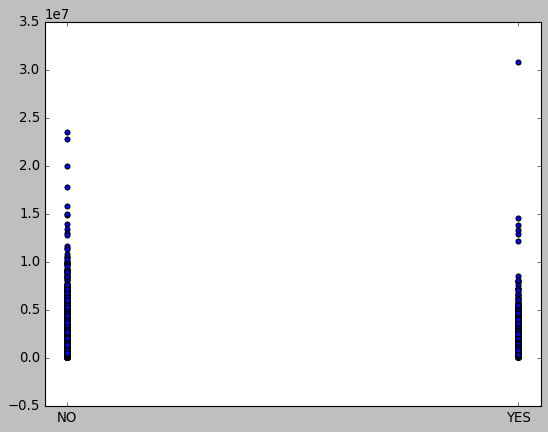

In [93]:
plt.scatter(x=df['nuisance'], y=df['price'])

In [94]:
# convert nuisance into numeric boolean
greenbelt_bool_dict = {'YES':1,'NO':0,np.nan:0}
df_categorical.greenbelt.replace(to_replace=greenbelt_bool_dict,inplace=True)

In [95]:
df['view'].unique()

array(['NONE', 'AVERAGE', 'EXCELLENT', 'FAIR', 'GOOD'], dtype=object)

In [96]:
# convert view from string into categorical ordinal
view_dict = {'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}
df_categorical.view.replace(to_replace=view_dict,inplace=True)

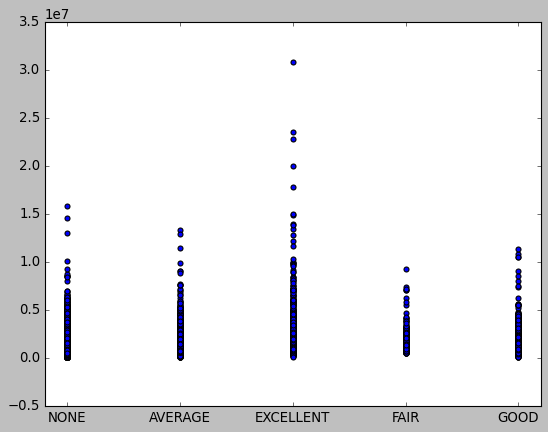

In [97]:
plt.scatter(x=df['view'], y=df['price'])

In [98]:
df['heat_source'].unique()

array(['Gas', 'Oil', 'Electricity', 'Gas/Solar', 'Electricity/Solar',
       'Other', 'Oil/Solar'], dtype=object)

In [99]:
heat_source_dummies = pd.get_dummies(df['heat_source'], prefix='heat_source',drop_first=True)
heat_source_dummies

,heat_source_Electricity/Solar,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other
0,0,1,0,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
30150,0,0,0,1,0,0
30151,0,1,0,0,0,0
30152,0,1,0,0,0,0
30153,0,1,0,0,0,0


In [100]:
df['sewer_system'].unique()

array(['PUBLIC', 'PRIVATE', 'PRIVATE RESTRICTED', 'PUBLIC RESTRICTED'],
      dtype=object)

In [101]:
sewer_dummies = pd.get_dummies(df['sewer_system'],prefix='sewer', drop_first=True)
sewer_dummies

,sewer_PRIVATE RESTRICTED,sewer_PUBLIC,sewer_PUBLIC RESTRICTED
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
30150,0,1,0
30151,0,1,0
30152,0,1,0
30153,0,1,0


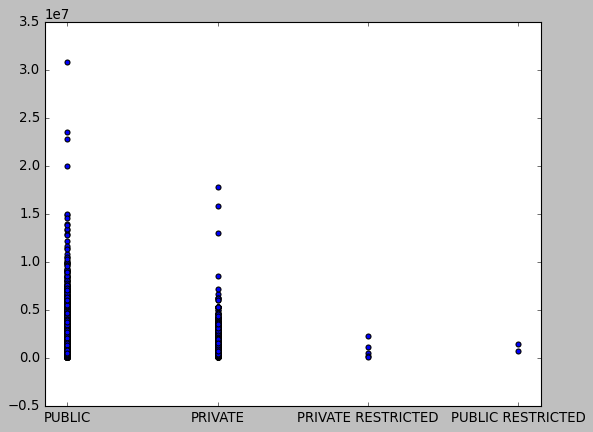

In [102]:
plt.scatter(x=df['sewer_system'], y=df['price'])

### Developing categorical dataframe

In [103]:
df_cat_pick = df_categorical[['waterfront','nuisance','view','greenbelt']]

## Model #2

In [104]:
model_2_data = pd.concat([df_numerical,sewer_dummies,heat_source_dummies, df_cat_pick], axis = 1)

In [105]:
len(model_2_data) == len(waterfront_dummies)

True

In [106]:
model_2_data.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_garage',
       'sqft_patio', 'yr_built', 'yr_renovated', 'lat', 'long',
       'school_rating', 'month', 'day_of_year', 'sewer_PRIVATE RESTRICTED',
       'sewer_PUBLIC', 'sewer_PUBLIC RESTRICTED',
       'heat_source_Electricity/Solar', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'waterfront', 'nuisance', 'view', 'greenbelt'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     1177.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:30:49   Log-Likelihood:            -4.2978e+05
No. Observations:               29200   AIC:                         8.596e+05
Df Residuals:                   29168   BIC:                         8.599e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

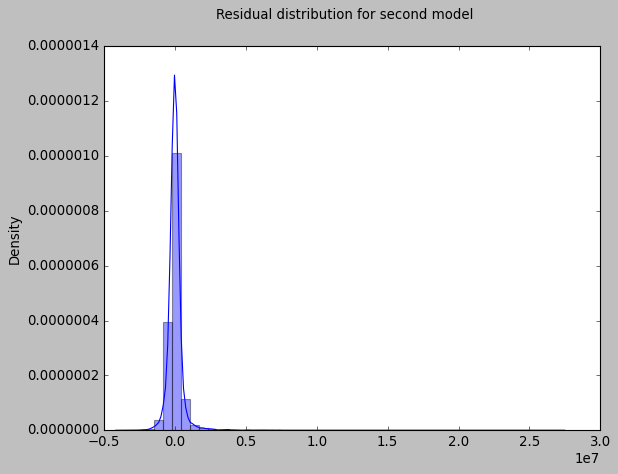

(None,
 Text(0.5, 0.98, 'Residual distribution for second model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [107]:
get_OLS_model('second',model_2_data, df['price'])

`heat_source`, `greenbelt` and `sewer_system` both have incredibly high p-values. These will be dropped from the final model if it holds. 

## Observations of Model 2

Model is still highly skewed although did present itself with some improvements. Next steps will be to normalize the data by transforming features that are skewed within the data, as well as remove outliers

- Jarque-Bera score is sky high and must come down for the model to hold any validity. 
- Durbin Watson score is in the acceptable range of 1.50-2.50
- Rsquared has 'improved' but only at the expense of the the continued flaws mentioned before. 

## Eliminating Outliers

To normalize the distribution, outlier removal will be the first step. An outlier will be defined as three standard deviations away from the mean of the target variable.

In [129]:
outlier_thresh = df['price'].std()*3 # value of the prices at the third standard deviation
df_outlier_removed = df.loc[abs(df['price']) <= outlier_thresh] # slicing all data within the defined range

# assign y as the target variable
y = df_outlier_removed['price']

In [130]:
model_2_data_outlier_removed = model_2_data.loc[abs(df['price']) <= outlier_thresh]

In [131]:
df_outlier_removed

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,water_Elliot Bay,water_Lake Sammamish,water_Lake Union,water_Lake Washington,water_Puget Sound,water_other,city,school_rating,month,day_of_year
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,0,0,0,0,0,1,renton,5.937719,5,144
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,0,0,0,0,0,1,seattle,6.500000,12,347
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,0,0,0,0,0,1,seattle,4.500000,9,272
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,0,0,0,0,0,1,seattle,4.000000,12,348
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,0,0,0,0,0,1,issaquah,5.937719,8,236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,2021-11-30,1555000.0,5,2.0,1910,4000,1.5,NO,NO,...,0,0,0,0,0,1,seattle,6.500000,11,334
30151,194000695,2021-06-16,1313000.0,3,2.0,2020,5800,2.0,NO,NO,...,0,0,0,0,0,1,seattle,7.666667,6,167
30152,7960100080,2022-05-27,800000.0,3,2.0,1620,3600,1.0,NO,NO,...,0,0,0,0,0,1,seattle,3.500000,5,147
30153,2781280080,2022-02-24,775000.0,3,2.5,2570,2889,2.0,NO,NO,...,0,0,0,0,0,1,renton,5.937719,2,55


In [132]:
waterfront_dummies = df_outlier_removed[['water_Elliot Bay','water_Lake Sammamish', 'water_Lake Washington','water_Puget Sound','water_other']]

In [133]:
df_outlier_removed.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'zipcode', 'waterfront_loc',
       'water_Elliot Bay', 'water_Lake Sammamish', 'water_Lake Union',
       'water_Lake Washington', 'water_Puget Sound', 'water_other', 'city',
       'school_rating', 'month', 'day_of_year'],
      dtype='object')

## New look at model with removed outliers

In [134]:
outlier_data = pd.concat([y,model_2_data_outlier_removed], axis=1)



In [135]:
outlier_data = outlier_data.drop('price', axis=1)

In [136]:
len(outlier_data)

28004

In [137]:
outlier_data

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,sqft_garage,...,heat_source_Electricity/Solar,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other,waterfront,nuisance,view,greenbelt
0,4,1.0,1180,7140,1.0,4,7,1180,0,0,...,0,1,0,0,0,0,0,0,0,0
1,5,2.5,2770,6703,1.0,3,7,1570,1570,0,...,0,0,0,1,0,0,0,1,2,0
2,6,2.0,2880,6156,1.0,3,7,1580,1580,0,...,0,1,0,0,0,0,0,0,2,0
3,3,3.0,2160,1400,2.0,3,9,1090,1070,200,...,0,1,0,0,0,0,0,0,2,0
4,2,2.0,1120,758,2.0,3,7,1120,550,550,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,5,2.0,1910,4000,1.5,4,8,1600,1130,0,...,0,0,0,1,0,0,0,0,0,0
30151,3,2.0,2020,5800,2.0,3,7,2020,0,0,...,0,1,0,0,0,0,0,0,1,0
30152,3,2.0,1620,3600,1.0,3,7,940,920,240,...,0,1,0,0,0,0,0,1,0,0
30153,3,2.5,2570,2889,2.0,3,8,1830,740,480,...,0,1,0,0,0,0,0,0,0,0


## Model #3

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     1559.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:34:05   Log-Likelihood:            -3.9305e+05
No. Observations:               28004   AIC:                         7.862e+05
Df Residuals:                   27972   BIC:                         7.864e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

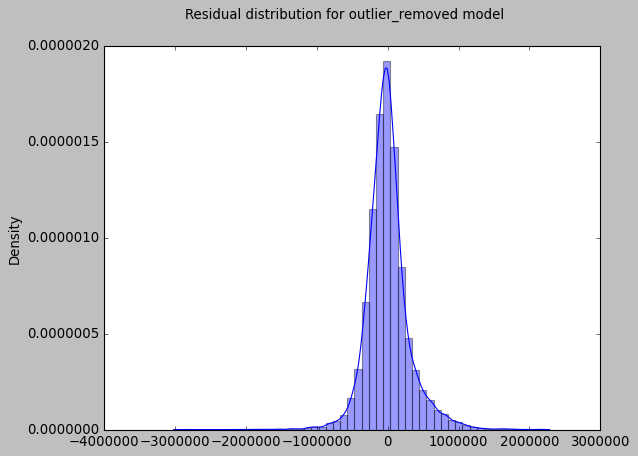

(None,
 Text(0.5, 0.98, 'Residual distribution for outlier_removed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [138]:
get_OLS_model('outlier_removed', outlier_data,y)

In [139]:
outlier_data.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_garage',
       'sqft_patio', 'yr_built', 'yr_renovated', 'lat', 'long',
       'school_rating', 'month', 'day_of_year', 'sewer_PRIVATE RESTRICTED',
       'sewer_PUBLIC', 'sewer_PUBLIC RESTRICTED',
       'heat_source_Electricity/Solar', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'waterfront', 'nuisance', 'view', 'greenbelt'],
      dtype='object')

## Observations of model 3
pvalue > 0.05
- `sqft_basement` 
- `sqft_garage`
- `sewer_PRIVATE RESTRICTED`
- `sewer_PUBLIC RESTRICTED`
- `heat_source_Electricity/Solar`
- `heat_source_Oil/Solar`
- `heat_source_Other`



- Adjusted rsquared indicates that the model explains 62.2% of the data.
- Skewness has improved dramatically to an acceptable range between -2 and 2. The removal of outliers has made this possible.
- Durbin-Watson score is still in the acceptable ranges of 1.5-2.5
- Jarque-Bera score is still very high but has been brought down by a significant factor. Still not perfect but trending in the right direction.
- Multicollinearity is possibly present in the model and likely so given the initial VIFs before the first model was built. VIFS should be revisited again to see if those variables are worth keeping. 

## Looking at log transformations for the price.

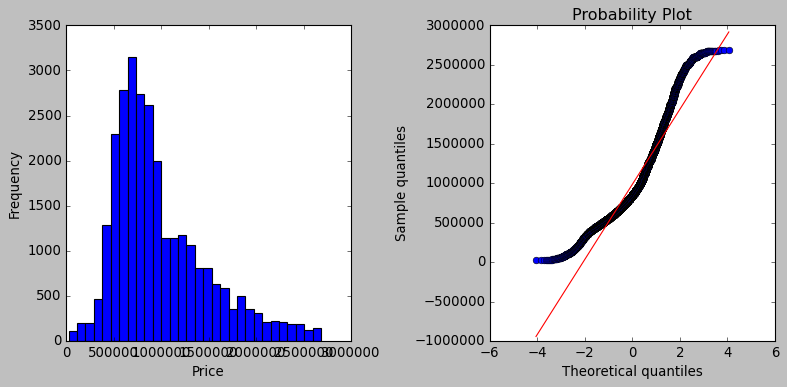

In [140]:
import scipy.stats as stats
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram on the first subplot
axs[0].hist(y, bins=30)
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')

# Plot QQ-plot on the second subplot
stats.probplot(y, plot=axs[1])
axs[1].set_xlabel('Theoretical quantiles')
axs[1].set_ylabel('Sample quantiles')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

As shown by the histogram of the price, we have a distribution that is heavily skewed right. The QQplot shows that the price follows an exponential pattern.

## Using log transformation to normally distribute the price data

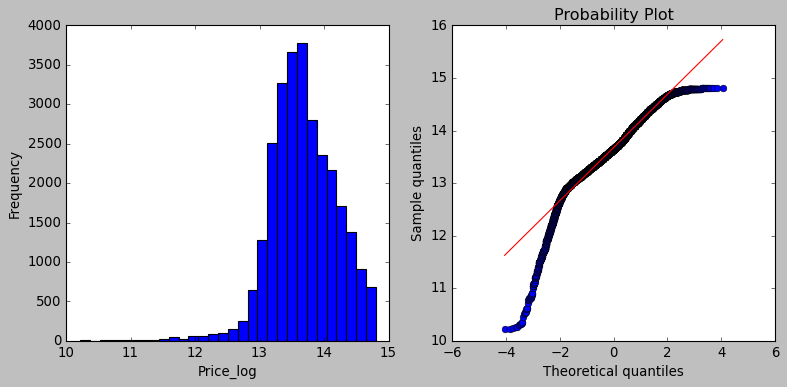

In [120]:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
y_log = np.log(y)
# Plot histogram on the first subplot
axs[0].hist(y_log, bins=30)
axs[0].set_xlabel('Price_log')
axs[0].set_ylabel('Frequency')

# Plot QQ-plot on the second subplot
stats.probplot(y_log, plot=axs[1])
axs[1].set_xlabel('Theoretical quantiles')
axs[1].set_ylabel('Sample quantiles')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

### Issue above is the data shows linearization everywhere but both tails of the data. Catching the lower tail will be the goal for the next test of transformation. For this, we will try a root transformation. 

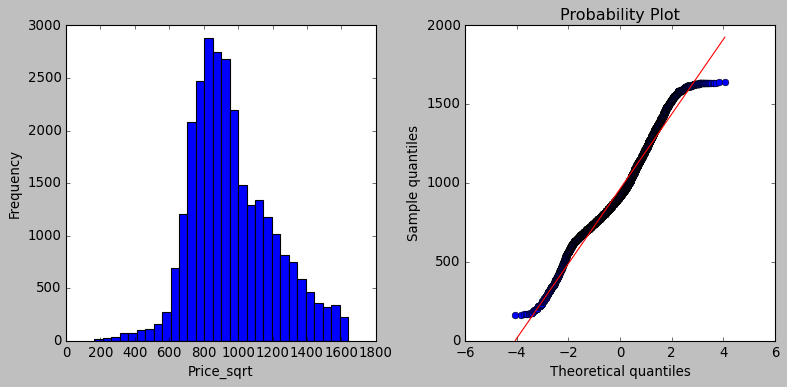

In [121]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
y_sqrt = y**0.5
# Plot histogram on the first subplot
axs[0].hist(y_sqrt, bins=30)
axs[0].set_xlabel('Price_sqrt')
axs[0].set_ylabel('Frequency')

# Plot QQ-plot on the second subplot
stats.probplot(y_sqrt, plot=axs[1])
axs[1].set_xlabel('Theoretical quantiles')
axs[1].set_ylabel('Sample quantiles')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

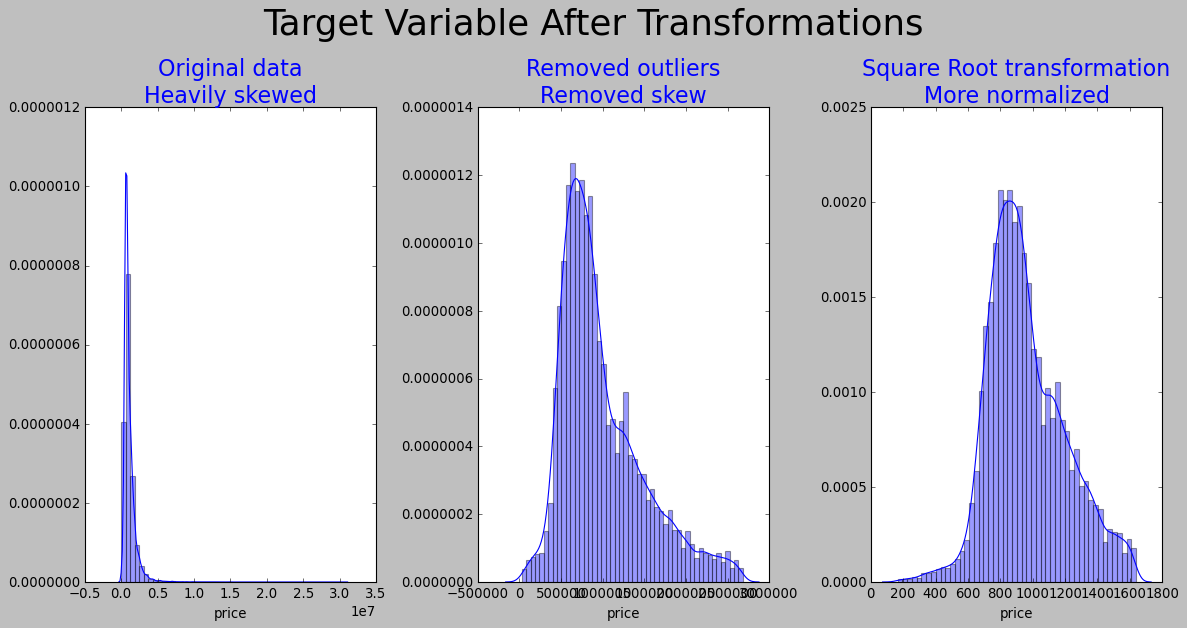

In [141]:
def plot_dist(ax, data, title):
    sns.distplot(data, ax=ax)
    ax.set_title(title, fontsize=20, color='b')
    ax.set_ylabel("")

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

# Plot the original data
plot_dist(ax1, df['price'], "Original data\nHeavily skewed")


# Plot the data with outliers removed
plot_dist(ax2, y, "Removed outliers\nRemoved skew")

# Apply square root transformation to the data
y_sqrt = np.sqrt(y)

# Plot the transformed data
plot_dist(ax3, y_sqrt, "Square Root transformation\nMore normalized")

# Set the overall title of the figure
fig.suptitle("Target Variable After Transformations", fontsize=32)

# Adjust the layout of the subplots
fig.tight_layout()

# Show the figure
plt.show()


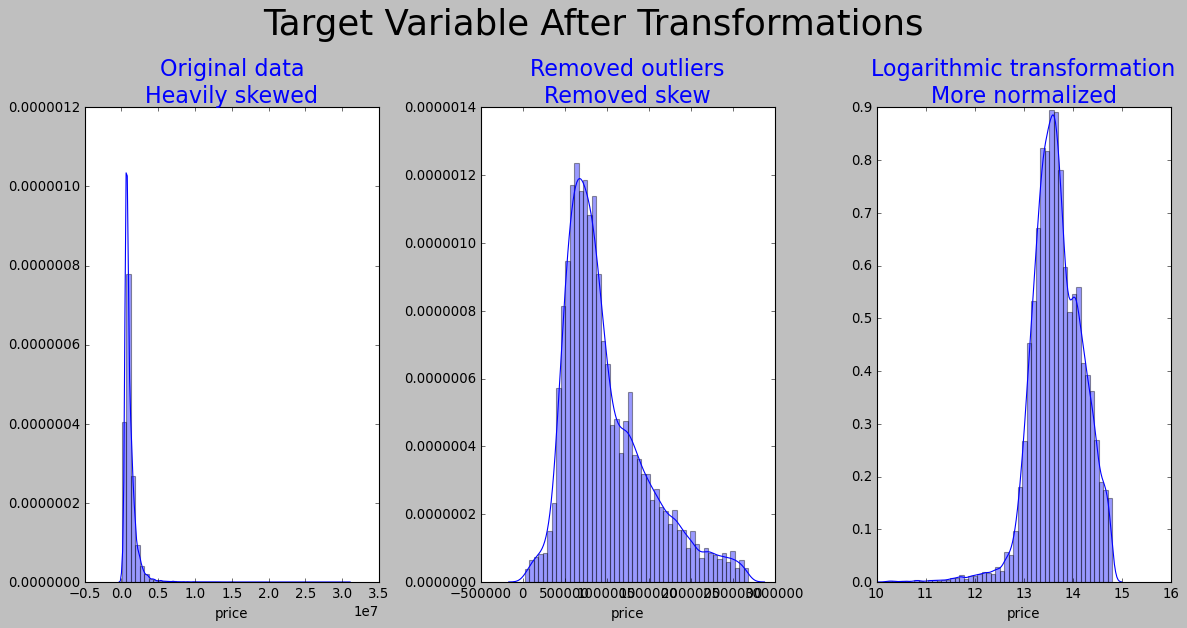

In [142]:
def plot_dist(ax, data, title):
    sns.distplot(data, ax=ax)
    ax.set_title(title, fontsize=20, color='b')
    ax.set_ylabel("")

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

# Plot the original data
plot_dist(ax1, df['price'], "Original data\nHeavily skewed")

# Plot the data with outliers removed
plot_dist(ax2, y, "Removed outliers\nRemoved skew")

# Apply square root transformation to the data
y__log = np.log(y)

# Plot the transformed data
plot_dist(ax3, y_log, "Logarithmic transformation\nMore normalized")

# Set the overall title of the figure
fig.suptitle("Target Variable After Transformations", fontsize=32)

# Adjust the layout of the subplots
fig.tight_layout()

# Show the figure
plt.show()


### Checking model with transformed target variable - square root transformation

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     1605.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:35:41   Log-Likelihood:            -1.7892e+05
No. Observations:               28004   AIC:                         3.579e+05
Df Residuals:                   27972   BIC:                         3.582e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

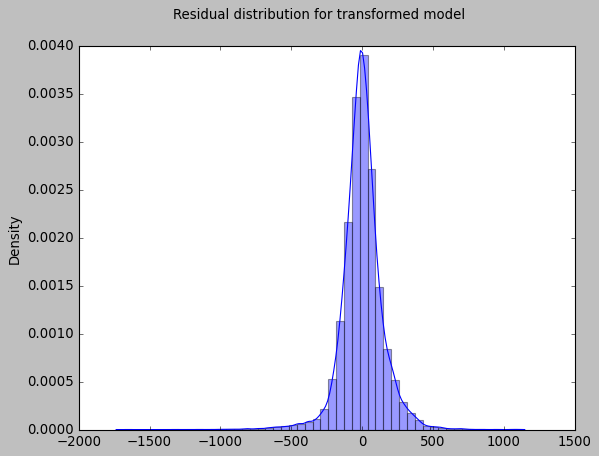

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [146]:
get_OLS_model('transformed', outlier_data, y_sqrt)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     1256.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:35:42   Log-Likelihood:                -8887.4
No. Observations:               28004   AIC:                         1.784e+04
Df Residuals:                   27972   BIC:                         1.810e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

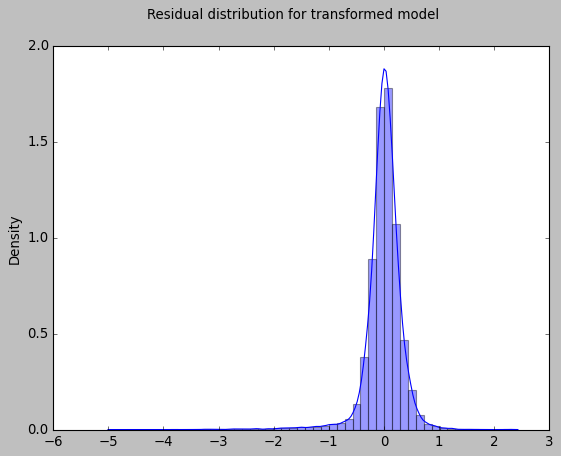

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [147]:
get_OLS_model('transformed', outlier_data, y_log)

## y_log vs y_sqrt

The model with the square root transformation appears to be less skewed and possesses a higher rsquared value, lending the ability of the model to explain more of the data. For these reasons we will use y_sqrt as our dependent variable for now until y_log appears to outweight the benefit of y_sqrt.

Jarque-Beras score is significantly better as well with the y_sqrt variable so I'll go with it for now. 

## Checking distribution of predictor

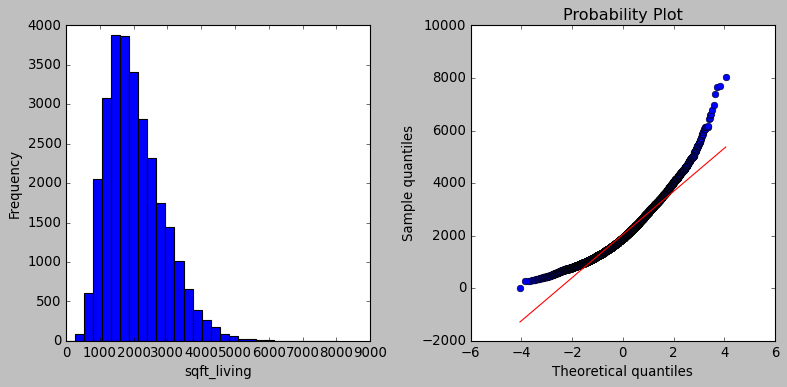

In [148]:
plot_hist_qq(outlier_data, 'sqft_living')

Data is clearly skewed right and follows an exponential pattern similar to price. For this, we will use a logarithmic transformation.

In [149]:
outlier_data['sqft_living_log'] = np.log(outlier_data['sqft_living']) 

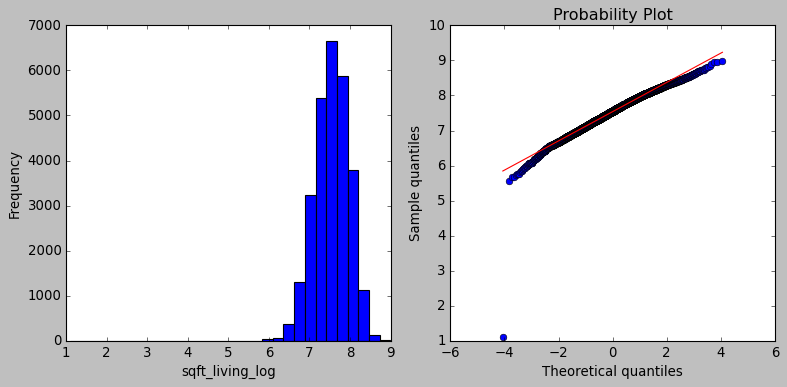

In [150]:
plot_hist_qq(outlier_data, 'sqft_living_log')

In [151]:
outlier_data = outlier_data.drop('sqft_living', axis=1)

In [152]:
outlier_data

,bedrooms,bathrooms,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,sqft_garage,sqft_patio,...,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other,waterfront,nuisance,view,greenbelt,sqft_living_log
0,4,1.0,7140,1.0,4,7,1180,0,0,40,...,1,0,0,0,0,0,0,0,0,7.073270
1,5,2.5,6703,1.0,3,7,1570,1570,0,240,...,0,0,1,0,0,0,1,2,0,7.926603
2,6,2.0,6156,1.0,3,7,1580,1580,0,0,...,1,0,0,0,0,0,0,2,0,7.965546
3,3,3.0,1400,2.0,3,9,1090,1070,200,270,...,1,0,0,0,0,0,0,2,0,7.677864
4,2,2.0,758,2.0,3,7,1120,550,550,30,...,0,0,0,0,0,0,1,0,0,7.021084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,5,2.0,4000,1.5,4,8,1600,1130,0,210,...,0,0,1,0,0,0,0,0,0,7.554859
30151,3,2.0,5800,2.0,3,7,2020,0,0,520,...,1,0,0,0,0,0,0,1,0,7.610853
30152,3,2.0,3600,1.0,3,7,940,920,240,110,...,1,0,0,0,0,0,1,0,0,7.390181
30153,3,2.5,2889,2.0,3,8,1830,740,480,100,...,1,0,0,0,0,0,0,0,0,7.851661


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     1591.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:35:47   Log-Likelihood:            -1.7900e+05
No. Observations:               28004   AIC:                         3.581e+05
Df Residuals:                   27972   BIC:                         3.583e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

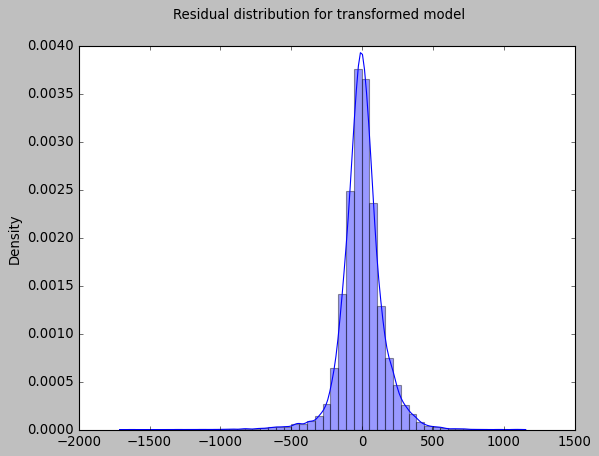

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [153]:
get_OLS_model('transformed', outlier_data, y_sqrt)

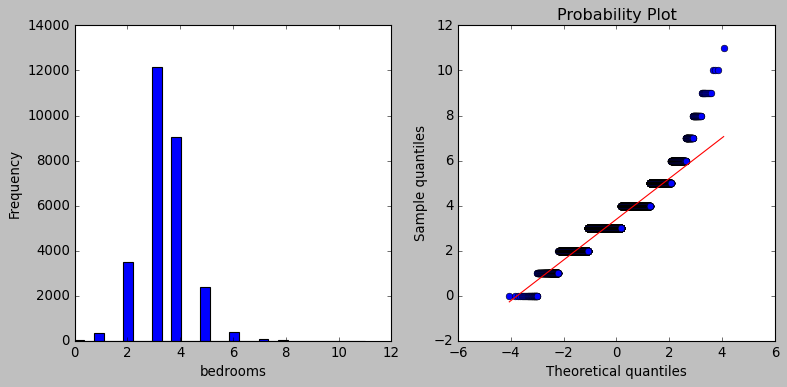

In [154]:
plot_hist_qq(outlier_data, 'bedrooms')

pval > 0.05

- `bedrooms` - will be dropped from the current model


In [155]:
outlier_data = outlier_data.drop(['bedrooms'], axis=1)

#### Rerun model

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     1644.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:35:50   Log-Likelihood:            -1.7900e+05
No. Observations:               28004   AIC:                         3.581e+05
Df Residuals:                   27973   BIC:                         3.583e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

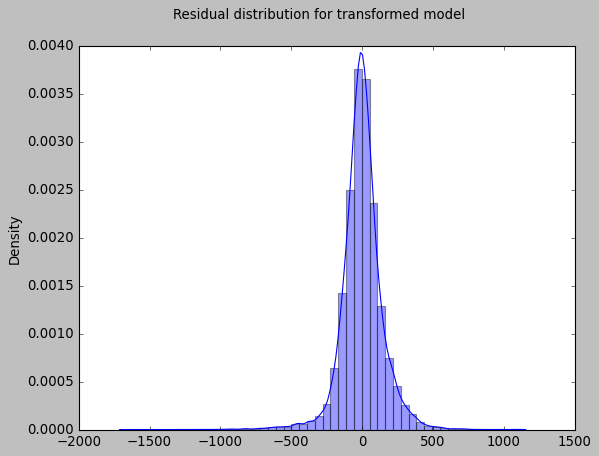

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [156]:
get_OLS_model('transformed', outlier_data, y_sqrt)

### Dropping sewer/heat source data

In [157]:
new_outlier_data = outlier_data.drop(['sewer_PRIVATE RESTRICTED','sewer_PUBLIC RESTRICTED', 'heat_source_Oil', 'heat_source_Oil/Solar', 'heat_source_Other', 'heat_source_Electricity/Solar'], axis =1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     2055.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:35:52   Log-Likelihood:            -1.7901e+05
No. Observations:               28004   AIC:                         3.581e+05
Df Residuals:                   27979   BIC:                         3.583e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -1.35e+

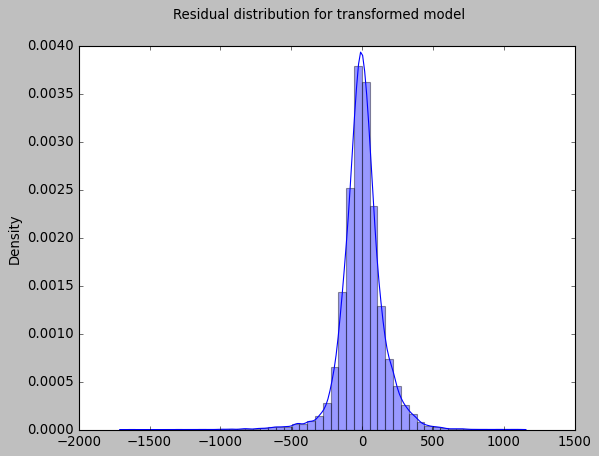

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [158]:
get_OLS_model('transformed', new_outlier_data, y_sqrt)

## Observations

- pval > 0.05

`bedrooms` - dropped from the current model

- all variables are statistically significant (pvalue < 0.05)
- Durbin-Watson Score continues to be "fine" but not improve a whole lot.
- Jarque-Bera Score continues to improve but still must come down
- skewness is now an afterthought as its at a very low -0.347
Overall no real improvement of the model happens here, we will try adding in new variables to improve as well as revisit VIFs to likely drop all that were originally at extremely high levels. 


Next steps to improve the model:
1. revisit VIFs to see if any variables(now that outliers are removed and data has been transformed) should now be dropped from the model. 
2. New predictors will be engineered to be added to the model. The next focus will be on the zipcodes in an attempt to narrow down the data with location-dependent price points. Possible data to be looked at are:
- waterfronts 
- views
- school districts: rating, and school taxes
- tax brackets



Jarque-Beras score and skew level continue to improve but there is still some work to do. 

## Rechecking VIFs

In [159]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your data into a pandas DataFrame
data = new_outlier_data

# Get a list of the column names
cols = data.columns

# Create an empty DataFrame to hold the VIF results
vif_data = pd.DataFrame()

# Loop through each column and calculate the VIF
for i in range(len(cols)):
    vif = variance_inflation_factor(data[cols].values, i)
    vif_data = vif_data.append({'Variable': cols[i], 'VIF': vif}, ignore_index=True)

# Print the VIF results
print(vif_data)

                 Variable            VIF
0               bathrooms      24.288846
1                sqft_lot       1.299746
2                  floors      17.348050
3               condition      31.675593
4                   grade     139.069100
5              sqft_above      48.182817
6           sqft_basement       4.898548
7             sqft_garage       4.596102
8              sqft_patio       2.243068
9                yr_built    9648.237288
10           yr_renovated       1.206333
11                    lat  134915.436533
12                   long  146175.174281
13          school_rating      22.303406
14                  month     699.107278
15            day_of_year     614.257403
16           sewer_PUBLIC       8.789766
17        heat_source_Gas       3.863875
18  heat_source_Gas/Solar       1.015124
19             waterfront       1.202711
20               nuisance       1.268682
21                   view       1.425945
22              greenbelt       1.061947
23        sqft_l

In [160]:
scaledX = (new_outlier_data - np.mean(new_outlier_data)) / np.std(new_outlier_data)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     2055.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:35:56   Log-Likelihood:            -1.7901e+05
No. Observations:               28004   AIC:                         3.581e+05
Df Residuals:                   27979   BIC:                         3.583e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   963.82

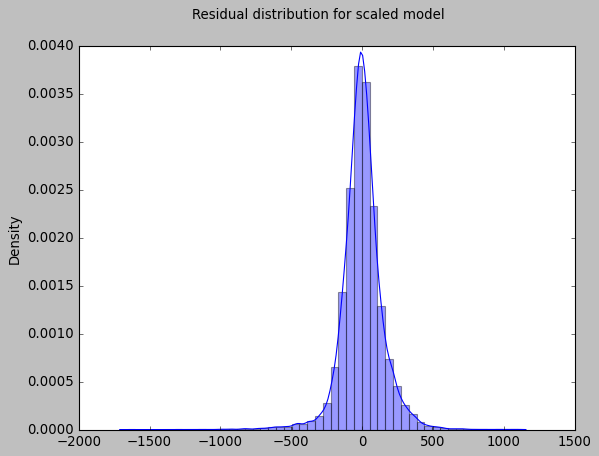

(None,
 Text(0.5, 0.98, 'Residual distribution for scaled model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [161]:
get_OLS_model('scaled',scaledX, y_sqrt)

In [162]:
water_data = pd.concat([scaledX,waterfront_dummies], axis=1)

In [163]:
water_data

,bathrooms,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,...,waterfront,nuisance,view,greenbelt,sqft_living_log,water_Elliot Bay,water_Lake Sammamish,water_Lake Washington,water_Puget Sound,water_other
0,-1.550443,-0.164735,-0.921374,0.71675,-0.524197,-0.741240,-0.832829,-1.180691,-0.712477,-0.139513,...,-0.111356,-0.452302,-0.328057,-0.161635,-1.110642,0,0,0,0,1
1,0.278402,-0.172652,-0.921374,-0.69289,-0.524197,-0.238814,1.993054,-1.180691,0.148366,-0.742388,...,-0.111356,2.210914,2.214330,-0.161635,0.925400,0,0,0,0,1
2,-0.331213,-0.182563,-0.921374,-0.69289,-0.524197,-0.225931,2.011053,-1.180691,-0.884646,-0.552006,...,-0.111356,-0.452302,2.214330,-0.161635,1.018318,0,0,0,0,1
3,0.888017,-0.268735,0.906427,-0.69289,1.394958,-0.857185,1.093091,-0.456052,0.277493,1.161428,...,-0.111356,-0.452302,2.214330,-0.161635,0.331912,0,0,0,0,1
4,-0.331213,-0.280367,0.906427,-0.69289,-0.524197,-0.818537,0.157130,0.812065,-0.755519,1.224889,...,-0.111356,2.210914,-0.328057,-0.161635,-1.235156,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,-0.331213,-0.221627,-0.007473,0.71675,0.435381,-0.200165,1.201087,-1.180691,0.019240,-1.662566,...,-0.111356,-0.452302,-0.328057,-0.161635,0.038423,0,0,0,0,1
30151,-0.331213,-0.189013,0.906427,-0.69289,-0.524197,0.340909,-0.832829,-1.180691,1.353547,1.193159,...,-0.111356,-0.452302,0.943136,-0.161635,0.172025,0,0,0,0,1
30152,-0.331213,-0.228874,-0.921374,-0.69289,-0.524197,-1.050426,0.823102,-0.311125,-0.411182,0.685474,...,-0.111356,2.210914,-0.328057,-0.161635,-0.354494,0,0,0,0,1
30153,0.278402,-0.241756,0.906427,-0.69289,0.435381,0.096137,0.499116,0.558442,-0.454224,1.034507,...,-0.111356,-0.452302,-0.328057,-0.161635,0.746591,0,0,0,0,1


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1739.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:35:59   Log-Likelihood:            -1.7881e+05
No. Observations:               28004   AIC:                         3.577e+05
Df Residuals:                   27974   BIC:                         3.579e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   976.68

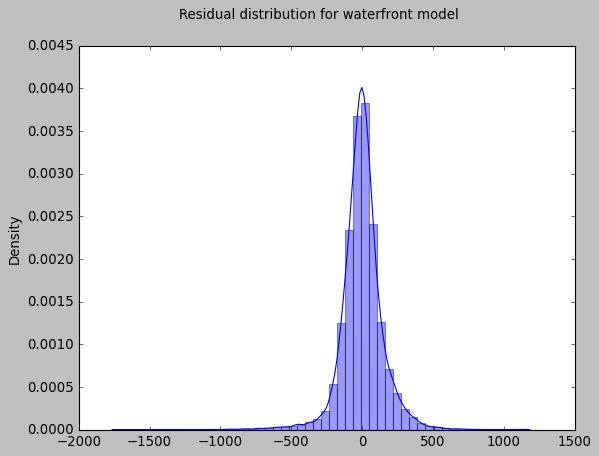

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [164]:
get_OLS_model('waterfront',water_data,y_sqrt)

Recheck VIFs

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1739.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:36:00   Log-Likelihood:            -1.7881e+05
No. Observations:               28004   AIC:                         3.577e+05
Df Residuals:                   27974   BIC:                         3.579e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   976.68

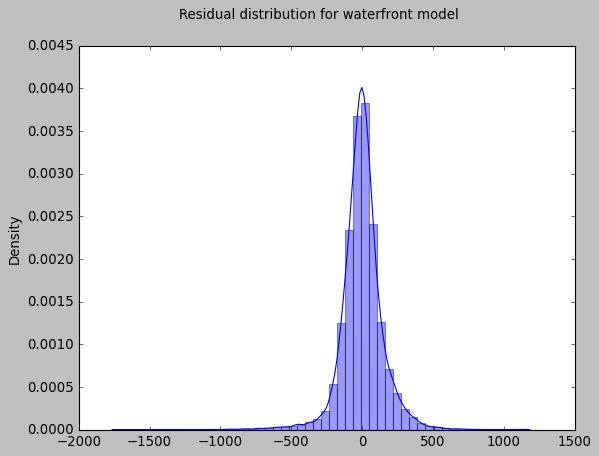

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [165]:
get_OLS_model('waterfront',water_data,y_sqrt)

In [166]:
get_vifs(water_data)

                 Variable         VIF
0               bathrooms    2.822804
1                sqft_lot    1.208206
2                  floors    2.097624
3               condition    1.266372
4                   grade    2.725830
5              sqft_above    7.945164
6           sqft_basement    2.958952
7             sqft_garage    1.954870
8              sqft_patio    1.259763
9                yr_built    2.782501
10           yr_renovated    1.158762
11                    lat    1.600118
12                   long    1.678620
13          school_rating    1.391443
14                  month  117.653613
15            day_of_year  117.640519
16           sewer_PUBLIC    1.498956
17        heat_source_Gas    1.236272
18  heat_source_Gas/Solar    1.012365
19             waterfront    1.194648
20               nuisance    1.056915
21                   view    1.290020
22              greenbelt    1.046094
23        sqft_living_log    8.332524
24       water_Elliot Bay    1.045566
25   water_L

In [167]:
water_data = water_data.drop(['month','day_of_year','water_other'], axis =1)

All VIFs are now below 10 with the majority less than 3, meaning the issue of collinearity is now for the most part solved. 

## Final model

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     1868.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:36:04   Log-Likelihood:            -1.7914e+05
No. Observations:               28004   AIC:                         3.583e+05
Df Residuals:                   27977   BIC:                         3.586e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   963.24

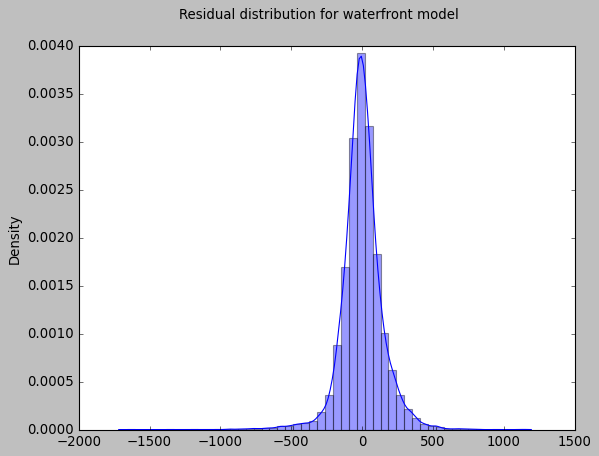

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [168]:
get_OLS_model('waterfront',water_data,y_sqrt)

In [169]:
get_vifs(water_data)

                 Variable       VIF
0               bathrooms  2.821525
1                sqft_lot  1.207911
2                  floors  2.097215
3               condition  1.265666
4                   grade  2.725160
5              sqft_above  7.943899
6           sqft_basement  2.958367
7             sqft_garage  1.953902
8              sqft_patio  1.259616
9                yr_built  2.780746
10           yr_renovated  1.158552
11                    lat  1.594011
12                   long  1.678245
13          school_rating  1.390952
14           sewer_PUBLIC  1.495867
15        heat_source_Gas  1.236225
16  heat_source_Gas/Solar  1.012346
17             waterfront  1.194586
18               nuisance  1.056613
19                   view  1.289979
20              greenbelt  1.046036
21        sqft_living_log  8.332167
22       water_Elliot Bay  1.045548
23   water_Lake Sammamish  1.183776
24  water_Lake Washington  1.161535
25      water_Puget Sound  1.055318


In [170]:
water_data = water_data.drop(['sqft_living_log'], axis =1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     1940.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:36:07   Log-Likelihood:            -1.7916e+05
No. Observations:               28004   AIC:                         3.584e+05
Df Residuals:                   27978   BIC:                         3.586e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   963.23

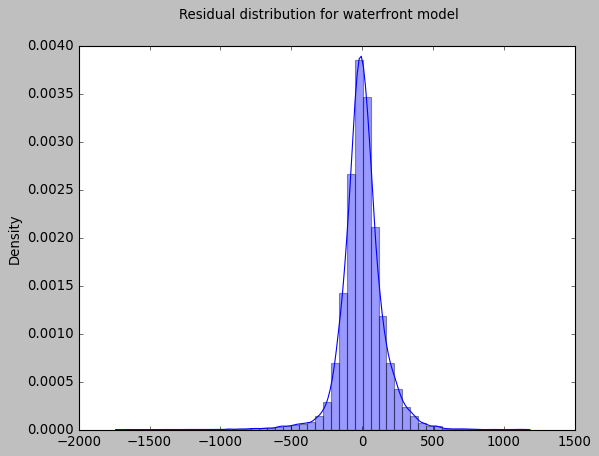

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [171]:
get_OLS_model('waterfront',water_data,y_sqrt)

In [172]:
get_vifs(water_data)

                 Variable       VIF
0               bathrooms  2.613181
1                sqft_lot  1.206485
2                  floors  2.085134
3               condition  1.240220
4                   grade  2.686084
5              sqft_above  3.274387
6           sqft_basement  1.792147
7             sqft_garage  1.936027
8              sqft_patio  1.258711
9                yr_built  2.764872
10           yr_renovated  1.156089
11                    lat  1.590733
12                   long  1.671893
13          school_rating  1.390790
14           sewer_PUBLIC  1.495842
15        heat_source_Gas  1.227726
16  heat_source_Gas/Solar  1.012330
17             waterfront  1.194429
18               nuisance  1.056327
19                   view  1.289824
20              greenbelt  1.046010
21       water_Elliot Bay  1.045322
22   water_Lake Sammamish  1.182965
23  water_Lake Washington  1.161392
24      water_Puget Sound  1.054799
